In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import statistics

# Classes

Normalize class handles the normalization of the data

In [45]:
class Normalize():
    def __init__(self, normType):
        self.normType = normType
    
    ## To do: add a statistical class function "znorm" which does the statistical norm
    
    def __call__(self, data):
        if self.normType=='min-max':
            return self.minmax(data)
        
        if self.normType=='znorm':
            return self.minmax(data)
        
    def minmax(self, data):
        return (data-np.min(data))/(np.max(data)-np.min(data))
    
    def znorm(self,data):
        stdev = statistics.stdev(data)
        mean = statistics.mean(data)
        return((data-mean)/stdev)


### Normalization

In [46]:
minmax = Normalize('min-max')
znorm = Normalize('znorm')
amp = df['Values'].values
time = df['Time'].values
ampMinMax = minmax(amp)
timeMinMax = minmax(time)
ampZnorm = znorm(amp)
timeZnorm = znorm(time)


### Min-Max Normalization

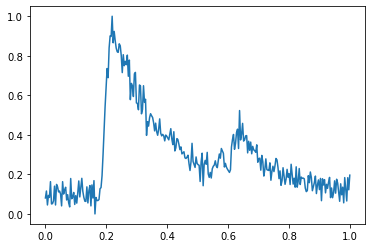

In [104]:
plt.plot(timeMinMax, 1-ampMinMax)

### Z Score Normalization

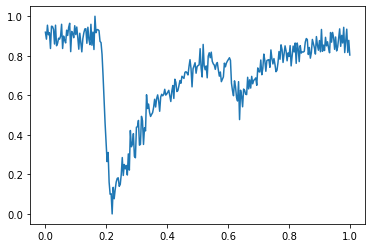

In [48]:
plt.plot(timeZnorm, ampZnorm)

## Errors

In [67]:
class Error():
    def __init__(self, errType):
        self.errType = errType
        
    def __call__(self, theory, predicted):
        if self.errType=='MSE':
            return self.calcMSE(theory, predicted)
        
        if self.errType=='RMSE':
            return self.calcRMSE(theory, predicted)
        
        if self.errType=='MAE':
            return self.calcMAE(theory, predicted)
                
        if self.errType=='MSLE':
            return self.calcMSLE(theory, predicted)

    def calcMSE(self,theory,predicted):
        # Calculate Error
        err = sum((predicted-theory)**2)/len(theory)
        return(err)

    def calcRMSE(self,theory,predicted):
        # Calculate Error
        err = (sum((predicted-theory)**2)/len(theory))**(0.5)
        return(err)

    def calcMAE(self,theory,predicted):
        # Calculate Error
        err = sum(abs(predicted-theory))/len(theory)
        return(err)


    def calcMSLE(self,theory,predicted):
        # Calculate Error
        err = sum(np.log(predicted+1)-np.log(theory+1))/len(theory)
        return(err)


## Derivatives

In [65]:
class Derivatives():
    def __init__(self, errType):
        self.errType = errType
        
    def __call__(self, theory, predicted,params,t):
        if self.errType=='MSE':
            return self.MSEderivatives(theory, predicted,params,t)
        
        if self.errType=='RMSE':
            return self.RMSEderivatives(theory, predicted,params,t)
        
        if self.errType=='MAE':
            return self.MAEderivatives(theory, predicted,params,t)
                
        if self.errType=='MSLE':
            return self.MSLEderivatives(theory, predicted,params,t)

    def MSEderivatives(self,theory,predicted,params,t):
        dA = 2*sum((predicted-theory)*np.exp(-(t-params[1])/params[2]))/len(theory)
        dB = 2*sum((predicted-theory)*(params[0]/params[2])*np.exp(-(t-params[1])/params[2]))/len(theory)
        dC = 2*sum((predicted-theory)*params[0]*np.exp(-(t-params[1])/params[2])*((t-params[1])/params[2]**2))/len(theory)
        return(dA,dB,dC)

    def RMSEderivatives(self,theory,predicted,params,t):
        # Function output multiplied by RMSE Chain Rule inside term derivative
        sa = sum((predicted-theory)*np.exp(-(t-params[1])/params[2]))/len(theory)
        sb = sum((predicted-theory)*(params[0]/params[2])*np.exp(-(t-params[1])/params[2]))/len(theory)
        sc = sum((predicted-theory)*params[0]*np.exp(-(t-params[1])/params[2])*((t-params[1])/params[2]**2))/len(theory)

        # Multiply by Chain Rule outside term derivative
        dA = sa/(sum(((predicted-theory)**2)/len(theory))**(0.5))
        dB = sb/(sum(((predicted-theory)**2)/len(theory))**(0.5))
        dC = sc/(sum(((predicted-theory)**2)/len(theory))**(0.5))

        return(dA,dB,dC)

    def MAEderivatives(self,theory,predicted,params,t):
        dA = sum(((predicted-theory)/(((predicted-theory)**2)**(0.5))*np.exp(-(t-params[1])/params[2])))/len(theory)
        dB = sum(((predicted-theory)/(((predicted-theory)**2)**(0.5))*np.exp(-(t-params[1])/params[2])))/len(theory)
        dC = sum(((predicted-theory)/(((predicted-theory)**2)**(0.5))*params[0]*np.exp(-(t-params[1])/params[2])*((t-params[1])/params[2]**2)))/len(theory)
        return(dA,dB,dC)

    def MSLEderivatives(self,theory,predicted,params,t):
        dA = sum((np.log(predicted+1)-np.log(theory+1))*np.exp(-(t-params[1])/params[2]))/len(theory)
        dB = sum((np.log(predicted+1)-np.log(theory+1))*np.exp(-(t-params[1])/params[2]))/len(theory)
        dC = sum((np.log(predicted+1)-np.log(theory+1))*params[0]*np.exp(-(t-params[1])/params[2])*((t-params[1])/params[2]**2))/len(theory)
        return(dA,dB,dC)


## Trainer

In [61]:
dict ={
'error': 'rmse',
'normalization': 'max-min',
'learning rate': 1e-3,
}


In [70]:
class Trainer():
    
    # Input error function, normalization class, learning rate
    # In Initialize it should create the random parameters
    # initialize the fit function
    # Call function should input the data we want to fit (time and amplitude), within here it should call:
    ## Calculate loss
    ## Claculate derivitive
    ## Update params 
    ## Update array with loss 
    ### Object here should have loss and the parameters 

    def __init__(self, error, norm, learningRate):
        self.errType = error
        self.normType = norm
        self.learningRate = learningRate
        self.params = np.random.rand(3)

        self.loss = []
                              
    def __call__(self, time, amp, epochs):
        # Get Functions based on input Params
        norm = Normalize(self.normType)
        calcError = Error(self.errType)
        calcDerivs = Derivatives(self.errType)
        timeNorm = norm(time)
        ampNorm = norm(amp)
        
        for i in range (0,epochs):
            pred = self.fitFunction(timeNorm)
            
            dA, dB, dC = calcDerivs(ampNorm,pred,self.params,timeNorm)

            self.params[0]=self.params[0]-self.learningRate*dA
            self.params[1]=self.params[1]-self.learningRate*dB
            self.params[2]=self.params[2]-self.learningRate*dC
            
            error = calcError(ampNorm,pred)
            
            self.loss.append(error)
            
        return {'error': self.errType, 'normalization': self.normType, 'learning rate': self.learningRate,  'params':self.params, 'loss': self.loss}
        
    def fitFunction(self, t):
        return self.params[0]*np.exp(-(t-self.params[1])/(self.params[2]))

In [53]:
df = pd.read_csv('data.txt',sep='\t', header=(0))
df

,Time,Values
0,623.5183,9.238760e-07
1,623.5683,-1.102690e-06
2,623.6183,2.980250e-06
3,623.6683,1.788150e-07
4,623.7183,7.748640e-07
...,...,...
297,638.3683,-1.698740e-06
298,638.4183,1.817950e-06
299,638.4683,-5.006820e-06
300,638.5183,-1.460320e-06


In [54]:
time = df['Time'].values
amp = df['Values'].values

In [71]:
output = []
trials = [{
    'error': 'rmse',
    'normalization': 'max-min',
    'learning rate': 1e-3,
}]

epochs = 1500

trainer = Trainer(error = trials[0]['error'], norm = trials[0]['normalization'], learningRate = trials[0]['learning rate'])

[-0.35372893  0.84334292  1.73211918]
[-7.27863878e-05  6.36210611e+02  1.73211918e+00]


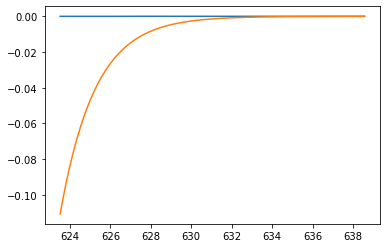

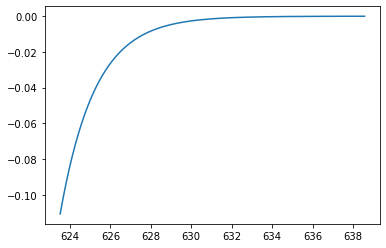

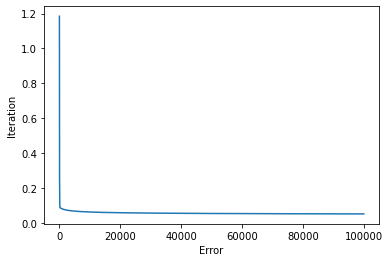

In [111]:
def fitFunction(params,t):
    return params[0]*np.exp(-(t-params[1])/(params[2]))

learningRate = 0.001
norm = Normalize('min-max')
calcError = Error('MSE')
calcDerivs = Derivatives('MSE')
timeNorm = norm(time)
ampNorm = norm(amp)

# Slice desired portion
timeNorm = timeNorm[64:150]
ampNorm = ampNorm[64:150]

# Flip amplitude
ampNorm = -ampNorm

loss = []
loop = []

params = np.random.rand(3)

for i in range (0,100000):
    pred = fitFunction(params,timeNorm)

    dA, dB, dC = calcDerivs(ampNorm,pred,params,timeNorm)
    
    params[0]=params[0]-learningRate*dA
    params[1]=params[1]-learningRate*dB
    params[2]=params[2]-learningRate*dC

    error = calcError(ampNorm,pred)

    loss.append(error)
    loop.append(i)

    
plt.plot(time, -amp)

print(params)

params[0]=(params[0]*(max(df['Values'])-min(df['Values']))+min(df['Values']))
params[1]=(params[1]*(max(df['Time'])-min(df['Time']))+min(df['Time']))

print(params)

y = fitFunction(params,time)
plt.plot(time,y)

plt.figure()
plt.plot(time,y)


plt.figure()

plt.xlabel("Error")
plt.ylabel("Iteration")

plt.plot(loop,loss, label="MSE")